# Fractals, Newton's Method, and the Roots of Unity

This is a tutorial giving an interactive introduction to the Newton-Rhapson method for solving equations, where we are going to be producing some cool pictures as seen below. You can download this file from [this GitHub repository](https://github.com/CodyEthanJordan/TutorialNotebooks/blob/master/Fractals%2C%20Newton's%20Method%2C%20and%20the%20Roots%20of%20Unity%2C%20A%20Tutorial.ipynb) and run the code yourself, or if you don't have Jupyter notebooks installed on your machine [you can try this interactive version online](https://mybinder.org/v2/gh/CodyEthanJordan/TutorialNotebooks/master?filepath=Fractals%2C%20Newton's%20Method%2C%20and%20the%20Roots%20of%20Unity%2C%20A%20Tutorial.ipynb)

![Z^3 -1 = 0 basins of attraction](fractal.png)

#### What you should know

- Basic familiarity with Python. For more on that I'd reccomend [Think Python 2e](http://greenteapress.com/wp/think-python-2e/)
- Working knowledge of complex numbers. [Paul's Notes](http://tutorial.math.lamar.edu/Extras/ComplexPrimer/ComplexNumbers.aspx) is a great resouce for math subjects, in particular polar and exponential form is good to know


#### What we will cover

- Introduction to numerical methods, in particular the [Newton-Rhapson method](http://mathworld.wolfram.com/NewtonsMethod.html)
- How to use Python to make fractals from the basins of attraction from $z^3-1=0$ and other roots of unity
- Moving this code to the GPU by making a shader, see this [shadertoy implementation](https://www.shadertoy.com/view/WdV3R1)

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## Root Finding with Newton

Newton's method is a way to approximate the solution to an equation $f(x)=0$. In our case we are going to use this method to create fun shapes, but the method is equally viable for finding the answers to real equations.

The main advantages of Newton's method are
- as a numerical technique it doesn't require any understanding of exactly what $f$ is
- it is easy to explain

along with this come sown downsides
- as an approximation technique it will only get you close (probably very close) to the analytical answer
- there are much better methods (see: [the rest of numerical methods](https://en.wikipedia.org/wiki/Numerical_analysis))

If you want more background on Newton's method itself there are [numerous](https://tutorial.math.lamar.edu/classes/calci/newtonsmethod.aspx) [good](https://amsi.org.au/ESA_Senior_Years/SeniorTopic3/3j/3j_2content_2.html) [ones](http://numerical.recipes/).

Text(0.5,1,'$y = x^2 - 4$')

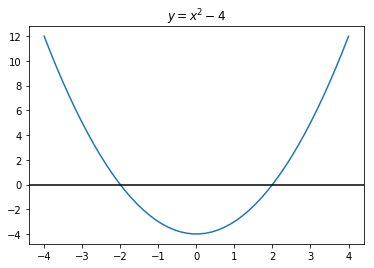

In [3]:
parabola = lambda x : x**2 - 4
parabolaSlope = lambda x : 2*x # this is the derivative of our function 
domain = np.linspace(-4,4)
plt.plot(domain, parabola(domain))
plt.axhline(0, color='black')
plt.title('$y = x^2 - 4$')

As a quick visual demonstration take a quadratic equation, something we already know what the answers should be so that it is easy to check that Newton's method is working as intended. In this case $f(x) = x^2 - 4 = 0$ has solutions $f(2)=0$, $f(-2)=0$.

Newton's method operates by taking an initial guess, and checking to see if this is close enough to 0. The "tolerance" variable controls how close to 0 you'll be satisfied with, make this smaller and you'll get a more accurate result, but in general more accuracy in numerical methods means a longer runtime.

In order to get to the next guess Newton's method uses the derivative of the function to effectively go downhill towards 0. 

>Note that the canny observer will recognize the disconnect between the earlier notion that we "don't need to know anything about f" in order to use numerical methods, yet here we assume that we have the derivative of f. This is not always an unreasonable assumption, but failing that you can then use [more numerical methods](https://en.wikipedia.org/wiki/Numerical_differentiation) to then in turn estimate $f'$ for use in estimating $f(x) = 0$

In [12]:
# pretend we are Newton-Rhapson
initialGuess = 4
tolerance = 0.1 # how close to 0 is good enough
if abs(parabola(initialGuess)) <= tolerance:
    print("We did it! Function has a 0 at " + str(initialGuess))
else:
    print("More work to do")

More work to do


In [13]:
offsetToNextGuess = -parabola(initialGuess) / parabolaSlope(initialGuess)
newGuess = initialGuess + offsetToNextGuess
print(newGuess)

2.5


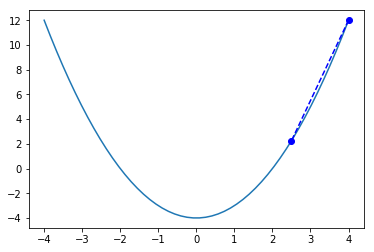

In [8]:
plt.plot(domain, parabola(domain), '-')
plt.plot([initialGuess, newGuess], [parabola(initialGuess), parabola(newGuess)], '--bo')

This represents a single step of Newton's method. Next we take our new guess and run the same procedure again, iterating until we are close enough to 0 that we claim victory and call it a day. Or at least until the program has run long enough and we have it bail out after taking too many iterations.

In [15]:
distanceFromZero = parabola(newGuess)
while distanceFromZero > tolerance: # keep going until we find a good solution
    offsetToNextGuess = -parabola(newGuess) / parabolaSlope(newGuess)
    newGuess = newGuess + offsetToNextGuess
    distanceFromZero = parabola(newGuess)
    print("Trying out: " + str(newGuess))

print("Answer is:" + str(newGuess))

Trying out: 2.000609756097561
Answer is:2.000609756097561


Something important to note here, in our example the parabola had 2 roots ($-2$ and $2$), but Newton's method only gave us one. This is a limitation of Newton's method, although one which we will exploit later. Try to change the initial guess and see which (if any) root Newton's method is able to find.

If you consider all of the start points which will eventually lead to $2$ this is called a [basin of attraction](http://www.acme.byu.edu/wp-content/uploads/2017/01/Vol1B-NewtonsMethod-2017.pdf). This is what makes the fractal pattern which we are building towards, we just color each basin a different color and see that even such a simple equation will produce intricate patterns. But first, its time for complex numbers.

# Roots of Unity and Generalizing Newton to Complex Numbers

The roots of unity are solutions to equations such as $z^n = 1$. When you look at these in the complex plane they are points evenly spaced around the unit circle. Specifically we're going to look at $z^3 = 1$ which has solutions $z = e^0, e^{i \frac{1}{3} 2\pi}, e^{i \frac{2}{3} 2\pi}$ 

If we want to use Newton's method to solve this we need to have a form which works with complex numbers. This section is a bit more advanced so feel free to just skip to the answer at the end. Or if you'd rather even more detail check out [The Newton and Halley Methods for Complex Roots](https://www.jstor.org/stable/2589209?seq=1#page_scan_tab_contents).

In order to find the basins of attraction for $z^3 - 1 = 0$ we have to generalize Newton's method to work with complex numbers. One way to do this is to treat our complex numbers as a pair of real numbers $z = x + i y, x, y \in \mathbb R$, and look at our function this way as well $f(z) = g(x,y) + i h(x,y)$. We will also need to keep in mind [the Cauchy-Riemann eqquations](http://mathworld.wolfram.com/Cauchy-RiemannEquations.html) which state

$$ \frac{\partial g}{\partial x} = \frac{\partial h}{\partial y},  \frac{\partial h}{\partial x} = -\frac{\partial g}{\partial y}$$




In [16]:
g = lambda x, y: x**3 - 3*x*y**2 - 1
h = lambda x, y: 3*x**2 * y - y**3
gx = lambda x, y: 3*x**2 - 3*y**2
gy = lambda x, y: -6*x*y
hx = lambda x, y: 6*x*y
hy = lambda x, y: 3*x**2 - 3*y**2

# render a PIXELS x PIXELS grid in the defined square
PIXELS = 400
minX = -1
maxX = 1
minY = -1
maxY = 1
points = np.array(np.meshgrid(np.linspace(minX, maxX, PIXELS),
    np.linspace(minY, maxY, PIXELS)))
colors = np.zeros((PIXELS, PIXELS))

In [17]:
def newtonIteration(point, g, h, gx, gy, hx, hy):
    x = point[0]
    y = point[1]
    nextX = x - (g(x,y)*hy(x,y) - h(x,y)*gy(x,y)) / (gx(x,y)*hy(x,y) - gy(x,y)*hx(x,y))
    nextY = y - (h(x,y)*gx(x,y) - g(x,y)*hx(x,y)) / (gx(x,y)*hy(x,y) - gy(x,y)*hx(x,y))
    return (nextX, nextY)

def delta(i, j):
    return (i[0] - j[0])**2 + (i[1]-j[1])**2

def complexNewton(initial, epsilon, maxIterations, g, h, gx, gy, hx, hy):
    current = initial
    prev = (np.inf, np.inf)
    iterations = 0
    while delta(prev, current) > epsilon:
        prev = current
        current = newtonIteration(current, g, h, gx, gy, hx, hy)
        iterations = iterations + 1
        if iterations > maxIterations:
            return (np.nan, np.nan)
    return current

Here is where the magic happens. 

For each pixel in our image we treat the coordinates of that pixel $(x,y)$ as an initial guess for where our equation is 0. $f(x+iy) = (x+iy)^3 - 1$. All of these guesses are wildly wrong, only 3 points on the entire plane will actually be where this equation is 0.

Next however Newton's method sets about using that initial guess to find a place where the equation is 0, then based on which of these 3 points the method ends up at, that is used to create a unique color for the initial point.

In [8]:
for x in range(PIXELS):
    for y in range(PIXELS):
        zeroFound = complexNewton(points[:, x, y], 0.0001, 10, g, h, gx, gy, hx, hy)
        colors[x,y] = np.sum(zeroFound)    

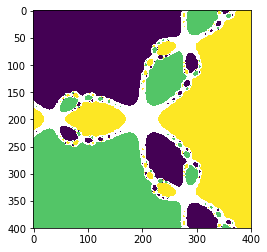

In [9]:
plt.imshow(colors)


And here is the image that produces. The trilateral symmetry is a good indicator that our program is working, as each of the 3 roots are more or less as good as the others. What I'd reccomend next is to go back through the code and alter a few things.

- Change the minimum and maximum X and Y values to "zoom in" or out on various areas to see how the complexity changes
- Try using z^4-1 = 0 as the base equation
- The white areas represent locations where Newton's method failed, probably due to numerical instability. What are some factors which could cause that?

From here you can take this a few ways. One is to focus on speeding this up with the GPU. Our method is running a calculation for each pixel in a target image, something which is the perfect description of a [fragment shader](https://www.shadertoy.com/view/WdV3R1).

The other is to begin investigating numerical methods on their own merits as a means to solve equations.

Or if you like cool fractals you can investigate other equations to use, check out the king of fractals [Inigo Quilez](https://www.iquilezles.org/index.html)

### Questions to consider

- Would a different language or implementation get better results?
- Many values get recomputed, are there reasonable ways to re-used previous calculations?
- How is the resulting image affected by floating point errors?